This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP). 

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).  

But, it’s not always clear whether a person’s words are actually announcing a disaster.In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.


**Brief description of the problem and data (5 pts)**

The goal is to build a model that correctly differentiates between real and non-real disasters through the data set of 10,000 tweets. 

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re, string, unicodedata

from tensorflow.keras.callbacks import ModelCheckpoint

from collections import Counter                                           # count the key-value pairs in an object
#!pip install contractions
import contractions                                     # Import contractions library.

from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator           # Used for plotting the wordcloud of a corpus

import nltk                                                               # Used for different task of NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer                                 # Used for removal of stop words
import warnings                                                           
warnings.filterwarnings("ignore")
from nltk.stem.porter import PorterStemmer                                #Used for Stemming of words in the corpus
nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/kgb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kgb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kgb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [255]:
# read files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [256]:
# Get the information of the training data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


There are total 7613 tweets. THere are few missing keywords and locations, but we have tweets for all ids. Each tweet has
- id - unique identified for a tweet
- keyword - keyword from the tweet. 
- location - location the tweet was sent from
- text - text of the tweeet
- tweet classification : Label. 1 relates to disaster tweet. 



In [257]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [258]:
# Dropping all the columns except text and target
train = train.drop(['id', 'keyword', 'location'], axis=1)
test = test.drop(['id', 'keyword', 'location'], axis=1)


In [259]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


**Text Preprosssing**
a. Html tag removal.
b. Tokenization.
c. Remove the numbers.
d. Removal of Special Characters and Punctuations.
e. Removal of stopwords
f. Conversion to lowercase.
g. Lemmatize or stemming.
h. Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.)
i. Print the first 5 rows of data after pre-processing.

In [260]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

train['text'] = train['text'].apply(lambda x: strip_html(x))
test['text'] = test['text'].apply(lambda x: strip_html(x))

train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [261]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

train['text'] = train['text'].apply(lambda x: replace_contractions(x))
test['text'] = test['text'].apply(lambda x: replace_contractions(x))

train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Pre-Processing : Remove Numbers

In [262]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

train['text'] = train['text'].apply(lambda x: remove_numbers(x))
test['text'] = test['text'].apply(lambda x: remove_numbers(x))

train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,", people receive #wildfires evacuation orders ...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Pre-Processing : Tokenization

In [263]:
train['text'] = train.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
test['text'] = test.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
train.head()

,text,target
0,"[Our, Deeds, are, the, Reason, of, this, #, ea...",1
1,"[Forest, fire, near, La, Ronge, Sask, ., Canada]",1
2,"[All, residents, asked, to, 'shelter, in, plac...",1
3,"[,, people, receive, #, wildfires, evacuation,...",1
4,"[Just, got, sent, this, photo, from, Ruby, #, ...",1


Pre-Processing : Remove Non-Ascii Characters

In [264]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

train['text'] = train['text'].apply(lambda x: remove_non_ascii(x))
test['text'] = test['text'].apply(lambda x: remove_non_ascii(x))
train.head()

,text,target
0,"[Our, Deeds, are, the, Reason, of, this, #, ea...",1
1,"[Forest, fire, near, La, Ronge, Sask, ., Canada]",1
2,"[All, residents, asked, to, 'shelter, in, plac...",1
3,"[,, people, receive, #, wildfires, evacuation,...",1
4,"[Just, got, sent, this, photo, from, Ruby, #, ...",1


Pre-Processing : Lower Case

In [265]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

train['text'] = train['text'].apply(lambda x: to_lowercase(x))
test['text'] = test['text'].apply(lambda x: to_lowercase(x))
train.head()

,text,target
0,"[our, deeds, are, the, reason, of, this, #, ea...",1
1,"[forest, fire, near, la, ronge, sask, ., canada]",1
2,"[all, residents, asked, to, 'shelter, in, plac...",1
3,"[,, people, receive, #, wildfires, evacuation,...",1
4,"[just, got, sent, this, photo, from, ruby, #, ...",1


Pre-Processing : Remove of Punctuation

In [266]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

train['text'] = train['text'].apply(lambda x: remove_punctuation(x))
test['text'] = test['text'].apply(lambda x: remove_punctuation(x))
train.head()

,text,target
0,"[our, deeds, are, the, reason, of, this, earth...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[all, residents, asked, to, shelter, in, place...",1
3,"[people, receive, wildfires, evacuation, order...",1
4,"[just, got, sent, this, photo, from, ruby, ala...",1


Pre-Processing : Stop Words

In [267]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',"hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stopwords = list(set(stopwords) - set(customlist))

In [268]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords:
            new_words.append(word)        # Append processed words to new list.
    return new_words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))
train.head()

,text,target
0,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[residents, asked, shelter, place, notified, o...",1
3,"[people, receive, wildfires, evacuation, order...",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


Pre-Processing : Lemmatization

In [269]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word))
    return new_words

train['text'] = train['text'].apply(lambda x: lemmatize_list(x))
test['text'] = test['text'].apply(lambda x: lemmatize_list(x))
train.head()

,text,target
0,"[deed, reason, earthquake, may, allah, forgive...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[resident, asked, shelter, place, notified, of...",1
3,"[people, receive, wildfire, evacuation, order,...",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


Pre-Processing - Normalization. Aggregrating pre-processing function into one.



In [270]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

train['text'] = train.apply(lambda row: normalize(row['text']), axis=1)
test['text'] = test.apply(lambda row: normalize(row['text']), axis=1)

In [271]:
train.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,people receive wildfire evacuation order calif...,1
4,got sent photo ruby alaska smoke wildfire pour...,1


In [272]:
X_train, y_train = train['text'], train['target']
X_test = test['text']

**Model Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

We will implement a sequential neural network model for sentimental analysis using LSTM layers. 

- Tokenization: The text data is tokenized using the Tokenizer class, which creates a word index based on the frequency of words in the training data.
- Conversion to sequences: The text data is converted to sequences of integers using the word index generated by the tokenizer.
- Padding sequences: The sequences are padded or truncated to ensure they all have the same length.
- Model construction: A sequential model is created with an embedding layer, followed by two LSTM layers and a dense layer for binary classification.
- Data type conversion: The input data is converted to NumPy arrays of type 'float32'.
- Model compilation: The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy metric.
- Model checkpointing: A callback is defined to save the best model based on validation accuracy during training.
- Model training: The model is trained using the fit method with the training data, number of epochs, batch size, and a validation split.

In [273]:
num_words = 10000
max_review_len = 100

In [274]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [275]:

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [276]:
X_train = pad_sequences(X_train, maxlen=max_review_len)
X_test = pad_sequences(X_test, maxlen=max_review_len)


In [277]:
# Build and train your sequential neural network model 
# You may use any RNN family neural network including LSTM, GRU, bidirectional RNN, etc.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(Embedding(num_words, 100, input_length=max_review_len))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))


2023-06-25 10:43:24.172254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 10:43:24.173737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 10:43:24.176032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [278]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [279]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [280]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [281]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [282]:

history = model.fit(X_train,y_train, epochs=15,batch_size=128,validation_split=0.1,callbacks=[checkpoint_callback])

Epoch 1/15


2023-06-25 10:43:24.925496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 10:43:24.928610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 10:43:24.930519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

54/54 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.6990

2023-06-25 10:44:09.059941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 10:44:09.062722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 10:44:09.064729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.79659, saving model to best_model.h5
54/54 [==============================] - 47s 760ms/step - loss: 0.5712 - accuracy: 0.6990 - val_loss: 0.4447 - val_accuracy: 0.7966
Epoch 2/15
54/54 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.8641
Epoch 2: val_accuracy did not improve from 0.79659
54/54 [==============================] - 41s 752ms/step - loss: 0.3333 - accuracy: 0.8641 - val_loss: 0.4614 - val_accuracy: 0.7717
Epoch 3/15
54/54 [==============================] - ETA: 0s - loss: 0.2291 - accuracy: 0.9127
Epoch 3: val_accuracy did not improve from 0.79659
54/54 [==============================] - 42s 784ms/step - loss: 0.2291 - accuracy: 0.9127 - val_loss: 0.5352 - val_accuracy: 0.7677
Epoch 4/15
54/54 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9375
Epoch 4: val_accuracy did not improve from 0.79659
54/54 [==============================] - 45s 825ms/step - loss: 0.1704 - accuracy: 0.

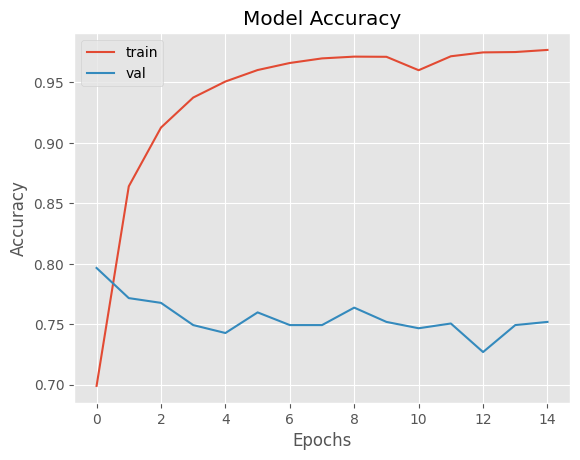

In [283]:
# Plot the training and validation accuracy and loss for each epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


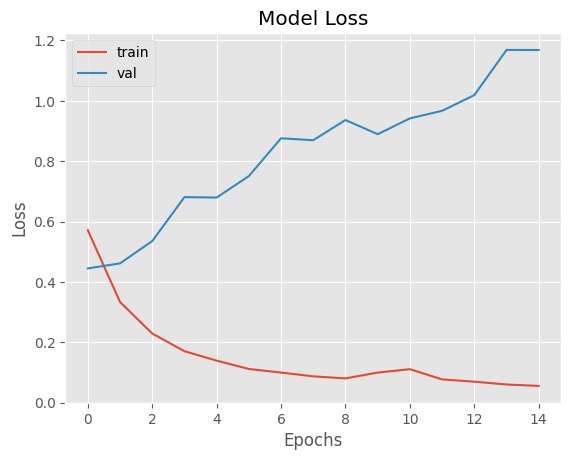

In [284]:
# Plot the trainng and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [285]:
submission = pd.read_csv('sample_submission.csv')
model.load_weights(model_save_path)
res = model.predict(X_test)


2023-06-25 10:54:40.950368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 10:54:40.952792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 10:54:40.954957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

102/102 [==============================] - 8s 66ms/step


In [287]:
from keras.backend import round as rnd
submission['target'] = np.asarray(rnd(res)).astype('int32')
submission.to_csv("submission.csv", index=False)

**Results and Analysis (35 pts)**

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

We will now perform hyperparameter optimiztion using grid search for a Keras model. Hyperparameters are configuration settings that are not learned from the data but instead need to be specified by the user. They can significantly affect the performance and generalization of a machine learning model.

We will  explore different combinations of hyperparameters for the Keras model and evaluate their performance using cross-validation. By doing so, we seek to identify the set of hyperparameters that yields the best performance on the given task.

Here's an overview of the main steps and intentions of the code:

- Define a function (create_model) to create a Keras model with configurable hyperparameters. This function serves as the blueprint for creating different model instances.
- Create an instance of KerasClassifier (model1) that wraps the create_model function. This allows the model to be treated as an estimator compatible with scikit-learn's grid search capabilities.
- Specify a grid of hyperparameters to search over, including the optimizer and dropout rate. This grid is defined in the param_grid dictionary.
- Instantiate a GridSearchCV object (grid) that performs the grid search, using the model1 estimator and the specified hyperparameter grid.
- Fit the grid object on the training data, which triggers the grid search process. The model is trained and evaluated for each combination of hyperparameters using cross-validation.
- Obtain the results and information about the best performing model from the grid_result object. This includes the best hyperparameters found and the corresponding evaluation scores.

The ultimate intention of the code is to identify the best hyperparameters for the Keras model, which can help improve its performance and generalization on the given task. By systematically searching and evaluating different combinations of hyperparameters, the code aims to find the optimal configuration for the model.

In [288]:
# optimize hyperparameters
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Embedding(num_words, 100, input_length=max_review_len))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=1)

optimizer = ['SGD', 'RMSprop', 'Adam']
dropout_rate = [0.0, 0.1]
param_grid = dict(optimizer=optimizer, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)


Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
40/40 [==============================] - 95s 2s/step - loss: 0.6884 - accuracy: 0.5799
Epoch 2/10
40/40 [==============================] - 105s 2s/step - loss: 0.6921 - accuracy: 0.5287
Epoch 2/10
40/40 [==============================] - 109s 3s/step - loss: 0.6883 - accuracy: 0.5790
Epoch 2/10
40/40 [==============================] - 111s 3s/step - loss: 0.6696 - accuracy: 0.5724
Epoch 2/10
40/40 [==============================] - 114s 3s/step - loss: 0.6639 - accuracy: 0.5965
Epoch 2/10
40/40 [==============================] - 114s 3s/step - loss: 0.6732 - accuracy: 0.5825
Epoch 2/10
40/40 [==============================] - 108s 3s/step - loss: 0.6831 - accuracy: 0.5801
Epoch 3/10
40/40 [==============================] - 110s 3s/step - loss: 0.6896 - accuracy: 0.5494
Epoch 3/10
40/40 [==============================] - 111s 3s/step - loss: 0.6827 - accuracy: 0.5816
Epoch 3/10
40/40 [==============================] - 117

2023-06-25 12:06:17.560983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 12:06:17.562402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 12:06:17.564097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-25 12:06:17.850074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 12:06:17.851931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 12:06:17.853350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 41s 616ms/step - loss: 0.6609 - accuracy: 0.5981
Epoch 2/10
60/60 [==============================] - 39s 656ms/step - loss: 0.5054 - accuracy: 0.7654
Epoch 3/10
60/60 [==============================] - 40s 667ms/step - loss: 0.3679 - accuracy: 0.8451
Epoch 4/10
60/60 [==============================] - 39s 648ms/step - loss: 0.3063 - accuracy: 0.8757
Epoch 5/10
60/60 [==============================] - 40s 661ms/step - loss: 0.2643 - accuracy: 0.8961
Epoch 6/10
60/60 [==============================] - 40s 670ms/step - loss: 0.2301 - accuracy: 0.9119
Epoch 7/10
60/60 [==============================] - 40s 667ms/step - loss: 0.1996 - accuracy: 0.9237
Epoch 8/10
60/60 [==============================] - 39s 657ms/step - loss: 0.1803 - accuracy: 0.9331
Epoch 9/10
60/60 [==============================] - 40s 674ms/step - loss: 0.1588 - accuracy: 0.9397
Epoch 10/10
60/60 [==============================] - 40s 667ms/step - loss: 0.1402 - accuracy: 0.9497


In [289]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.693682 using {'dropout_rate': 0.0, 'optimizer': 'RMSprop'}


In [290]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))





0.570337 (0.029691) with: {'dropout_rate': 0.0, 'optimizer': 'SGD'}
0.693682 (0.004101) with: {'dropout_rate': 0.0, 'optimizer': 'RMSprop'}
0.692893 (0.004564) with: {'dropout_rate': 0.0, 'optimizer': 'Adam'}
0.570337 (0.029691) with: {'dropout_rate': 0.1, 'optimizer': 'SGD'}
0.691057 (0.023970) with: {'dropout_rate': 0.1, 'optimizer': 'RMSprop'}
0.691450 (0.008655) with: {'dropout_rate': 0.1, 'optimizer': 'Adam'}


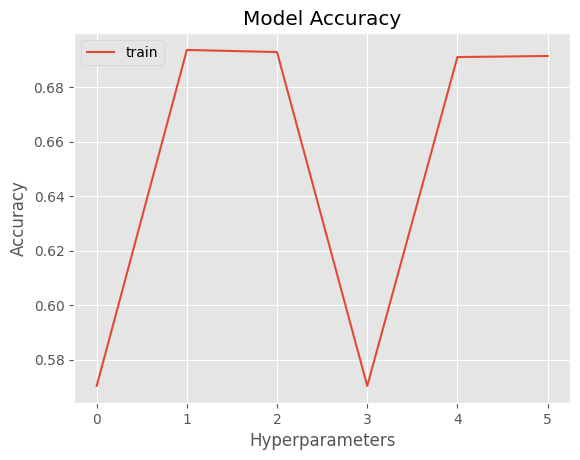

In [292]:
# Plot accuracy for gird search
plt.plot(means)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Hyperparameters')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


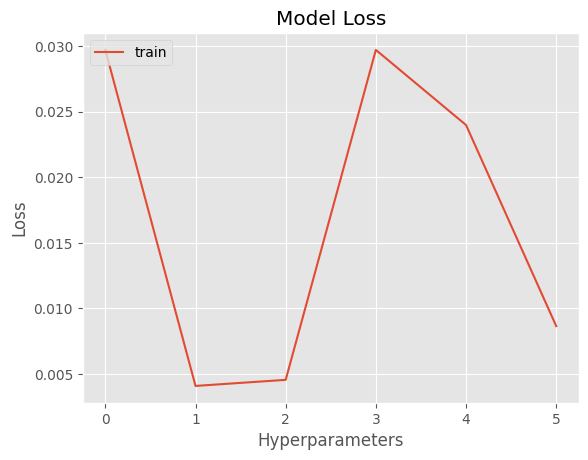

In [293]:
#Plot the training and validation loss for each grid search
plt.plot(stds)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Hyperparameters')
plt.legend(['train', 'val'], loc='upper left')

plt.show()


**Conclusion (15 pts)**

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

The results from gridsearch are not encouranging. The Optimizer RMSprop gives best score with drop out rate of 0.0.
